# Chapter 7 – Ensemble Learning and Random Forests
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alirezatheh/handson-ml3-notes/blob/main/notebooks/07_ensemble_learning_and_random_forests.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/alirezatheh/handson-ml3-notes/blob/main/notebooks/07_ensemble_learning_and_random_forests.ipynb)

Suppose we pose a complex question to thousands of random people, then aggregate their answers. In many cases we will find that this aggregated answer is better than an expert’s answer. This is called the *wisdom of the crowd*. Similarly, if we aggregate the predictions of a group of predictors, we will often get better predictions than with the best individual predictor. A group of predictors is called an *ensemble*; thus, this technique is called *ensemble learning*, and an ensemble learning algorithm is called an *ensemble method*.

## Voting Classifiers
The class that gets the most votes is the ensemble’s prediction. This majority-vote classifier is called a *hard voting classifier*.

How ensemble often achieves a higher accuracy than the best classifier? Suppose we have a slightly biased coin that has a 51% chance of coming up heads and 49% chance of coming up tails. If we do the math, we will find that the probability of obtaining a majority of heads after 1,000 tosses is close to 75%. The more we toss the coin, the higher the probability (e.g., with 10,000 tosses, the probability climbs over 97%). This is due to the *law of large numbers*: as we keep tossing the coin, the ratio of heads gets closer and
closer to the probability of heads (51%).

Similarly, if we build an ensemble containing 1,000 classifiers that are individually correct only 51% of the time (barely better than random guessing) and are perfectly independent, making uncorrelated errors, we can hope for up to 75% accuracy! But this is clearly not the case because they are trained on the same data.

**Tip**: Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.

Let’s try it on the moons dataset:

In [1]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42)),
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

When we fit a `VotingClassifier`, it clones every estimator and fits the clones. The original estimators are available via the `estimators` attribute, while the fitted clones are available via the `estimators_` attribute. To get dict instead use `named_estimators` or `named_estimators_` instead. Let’s look at each fitted classifier’s accuracy on the test set:

In [2]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, '=', clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


It performs hard voting:

In [3]:
voting_clf.predict(X_test[:1])

array([1])

In [4]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

Let’s look at the performance of the voting classifier on the test set:

In [5]:
voting_clf.score(X_test, y_test)

0.912

If all classifiers have a `predict_proba()` method, then we can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called *soft voting*:

In [6]:
voting_clf.voting = 'soft'
voting_clf.named_estimators['svc'].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

## Bagging and Pasting
Another approach is to use the same training algorithm for every predictor but train them on different random subsets of the training set. When sampling is performed *with* replacement, this method is called *bagging* (short for bootstrap aggregating, in statistics, resampling with replacement is called *bootstrapping*.) proposed in a 1996 paper [“Bagging Predictors”](https://homl.info/20) by Leo Breiman. When sampling is performed without replacement, it is called *pasting* proposed in a 1999 paper [“Pasting Small Votes for Classification in Large Databases and On-Line”](https://homl.info/21) by Leo Breiman. 

The aggregation function is typically the *statistical mode* for classification (hard voting), or the average for regression. Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.

Training and predictions can be made in parallel. This is one of the reasons bagging and pasting are popular: they scale very well.

### Bagging and Pasting in Scikit-Learn

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    n_jobs=-1,
    random_state=42,
)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

**Tip**: `max_samples` can also be a float between 0.0 and 1.0, in which case the max number of sampled instances is equal to the size of the training set times `max_samples`.

**Tip**: If we want to use pasting instead, just set `bootstrap=False`

**Note**: `BaggingClassifier` performs soft voting if the base classifier has a `predict_proba()` method.

Let's compare the decision boundary of a single decision tree with the decision boundary of a bagging ensemble of 500 trees:

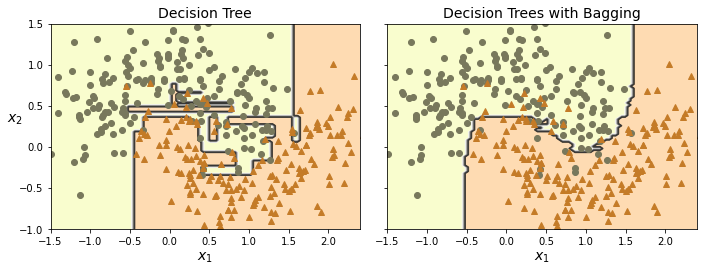

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import ArrayLike
from sklearn.pipeline import Pipeline

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


def plot_decision_boundary(
    clf: Pipeline, X: ArrayLike, y: ArrayLike, alpha: float = 1.0
) -> None:
    axes = [-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(
        np.linspace(axes[0], axes[1], 100), np.linspace(axes[2], axes[3], 100)
    )
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap='Greys', alpha=0.8 * alpha)
    colors = ['#78785c', '#c47b27']
    markers = ('o', '^')
    for idx in (0, 1):
        plt.plot(
            X[:, 0][y == idx],
            X[:, 1][y == idx],
            color=colors[idx],
            marker=markers[idx],
            linestyle='none',
        )
    plt.axis(axes)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$', rotation=0)


tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title('Decision Tree')
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title('Decision Trees with Bagging')
plt.ylabel('')
plt.show()

Bagging ends up with a slightly higher bias than pasting because it has it bit more diversity in the subsets that each predictor is trained on; but the extra diversity also means that the predictors end up being less correlated, so the ensemble’s variance is reduced. Overall, bagging often results in better models.

### Out-of-Bag evaluation
In bagging with `BaggingClassifier` by default it samples $m$ training instances with replacement (`bootstrap=True`). It can be shown mathematically that only about 63% of the training instances are sampled on average for each predictor (As $m$ grows, this ratio approaches $1–\exp(–1)\approx63\%$). The remaining 37% of the training instances that are not sampled are called *out-of-bag* (OOB) instances. Note that they are not the same 37% for all predictors.

A bagging ensemble can be evaluated using OOB instances, without the need for a separate validation set: if there are enough estimators, then each instance in the training set will likely be an OOB instance of several estimators, so these estimators can be used to make a fair ensemble prediction for that instance.

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    oob_score=True,
    n_jobs=-1,
    random_state=42,
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [10]:
# Probas for the first 3 instances
bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

In [11]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

The OOB evaluation was a bit too pessimistic.

If we randomly draw one instance from a dataset of size $m$, each instance in the dataset obviously has probability $1/m$ of getting picked, and therefore it has a probability $1–1/m$ of *not* getting picked. If we draw $m$ instances with replacement, all draws are independent and therefore each instance has a probability ${(1–1/m)}^m$ of *not* getting picked. Now let's use the fact that $\exp(x)=\lim_{m\to\infty}(1+x/m)^m$. So if $m$ is large, the ratio of out-of-bag instances will be about $\exp(-1)\approx0.37$. So roughly 63% (1 – 0.37) will be sampled.

In [12]:
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577


### Random Patches and Random Subspaces
With `BaggingClassifier` we can also sample features as well by two hyperparameters: `max_features` and `bootstrap_features`. They work the same way as `max_samples` and `bootstrap`. This technique is particularly useful when we are dealing with high-dimensional inputs (such as images) and results in even more predictor diversity, trading a bit more bias for a lower variance.

Sampling both training instances and features is called the *random patches* method proposed in 2012 paper [“Ensembles on Random Patches”](https://homl.info/22) by Gilles Louppe and Pierre Geurts. Keeping all training instances (by setting `bootstrap=False` and `max_samples=1.0`) but sampling features (by setting `bootstrap_features=True` and/or `max_features` to a value smaller than 1.0) is called the *random subspaces* method proposed in a 1998 paper [“The Random Subspace Method for Constructing Decision Forests”](https://homl.info/23) by Tin Kam Ho.

## Random Forests
A random forest as proposed in a paper [“Random Decision Forests”](https://homl.info/24) by Tin Kam Ho in 1995, is an ensemble of decision trees, generally trained via the bagging method (or sometimes pasting), typically with `max_samples` set to $m$:

In [13]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(
    n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42
)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

The random forest algorithm instead of searching for the very best feature when splitting a node, searches for the best feature among a random subset of features. By default, it samples $\sqrt{n}$ features. The algorithm results in greater tree diversity, trades a higher bias for a lower variance.

A Random Forest is equivalent to a bagging of decision trees:

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='sqrt', max_leaf_nodes=16),
    n_estimators=500,
    n_jobs=-1,
    random_state=42,
)

In [15]:
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)

True

### Extra-Trees
It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds. For this, simply set `splitter='random'` when creating a `DecisionTreeClassifier`.

A forest of such extremely random trees is called an *extremely randomized trees* (or *extra-trees* for short) ensemble, proposed by Pierre Geurts et al. in a 2006 paper [“Extremely Randomized Trees”](https://homl.info/25). This trades more bias for a lower variance and is faster to train than regular random forests.

Scikit-Learn provides `ExtraTreesClassifier` and `ExtraTreesRegressor` similar to `RandomForestClassifier` and `RandomForestRegressor`, except `bootstrap` defaults to `False`.

**Tip**: It is hard to know which between a random forest and extra-trees performs better. The only way to know is to try both.

### Feature Importance
Another great quality of random forests is that they easily measure the relative importance of each feature. Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average, across all trees in the forest. More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it:

In [16]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


Let's train a random forest classifier on the MNIST dataset and plot each pixel’s importance:

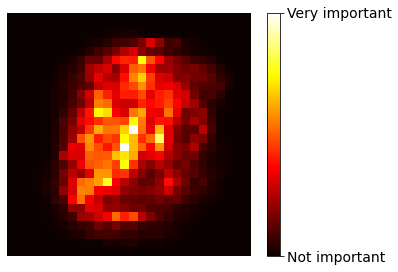

In [17]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap='hot')
cbar = plt.colorbar(
    ticks=[
        rnd_clf.feature_importances_.min(),
        rnd_clf.feature_importances_.max(),
    ],
)
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis('off')

plt.show()

## Boosting
*Boosting* (originally called *hypothesis boosting*) refers to any ensemble method that can combine several *weak* learners into a *strong* learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.

### AdaBoost
One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfit. This results in new predictors focusing more and more on the hard cases. This is the technique used by *AdaBoost* (short for *adaptive boosting*) proposed by Yoav Freund and Robert E. Schapire in 1997 paper [“A Decision-Theoretic Generalization of On-Line Learning and an Application to Boosting”](https://homl.info/26).

e.g., when training an AdaBoost classifier, the algorithm first trains a base classifier (such as a decision tree) and uses it to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on.

**Warning**: With this technique training cannot be parallelized since each predictor can only be trained after the previous predictor has been trained and evaluated. As a result, it does not scale as well as bagging or pasting.

Let’s take a look at the AdaBoost algorithm. Each instance weight $w^{(i)}$ is initially set to $1/m$.

**Equation 7-1** Weighted error rate of the $j^{\text{th}}$ predictor
$$
r_j
=\sum_{\begin{gathered}i=1\\\widehat{y}_j^{(i)}\neq y^{(i)}\end{gathered}}^m
w^{(i)}
$$
- $\widehat{y}_j^{(i)}$: The $j^{\text{th}}$ predictor’s prediction for the $i^{\text{th}}$ instance

**Equation 7-2** Predictor weight
$$
\alpha_j=\eta\log\frac{1-r_j}{r_j}
$$
- $\eta$: Defaults to 1.

**Equation 7-3** Weight update rule
$$
w^{(i)}\gets
\begin{cases}
w^{(i)}&\text{if}\;\widehat{y}_j^{(i)}=y^{(i)}
\\w^{(i)}\exp(\alpha_j)&\text{if}\;\widehat{y}_j^{(i)}\neq y^{(i)}
\end{cases}
$$

Then all the instance weights are normalized (i.e., divided by $\sum_{i=1}^mw^{(i)}$)

The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found. The predicted class is the one that receives the majority of weighted votes.

**Equation 7-4** AdaBoost predictions
$$
\widehat{y}(x)
=\underset{k}{\text{argmax}}\;
\sum_{\begin{gathered}j=1\\\widehat{y}_j(x)=k\end{gathered}}^N\alpha_j
$$
- $N$: The number of predictors

Scikit-Learn uses a multiclass version of AdaBoost called *SAMME* (which stands for *Stagewise Additive Modeling using a Multiclass Exponential loss function*) proposed by Ji Zhu et al. in 2009 paper [“Multi-Class AdaBoost”](https://homl.info/27). If the predictors have a `predict_proba()`, Scikit-Learn can use a variant of SAMME called *SAMME.R* (the *R* stands for “Real”), which relies on class probabilities rather than predictions and generally performs better.

**Note**: A *decision stump* is a decision tree with `max_depth=1` (one root two leaf). This is the default base estimator for the `AdaBoostClassifier`.

In [18]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=30,
    learning_rate=0.5,
    random_state=42,
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

**Tip**: If our AdaBoost ensemble is overfitting, we can try reducing the number of estimators or regularizing the base estimator.

### Gradient Boosting
*Gradient boosting* was first introduced in Leo Breiman’s 1997 paper [“Arcing the Edge”](https://homl.info/arcing) and was further developed in the 1999 paper [“Greedy Function Approximation: A Gradient Boosting Machine”](https://homl.info/gradboost) by Jerome H. Friedman. It is like AdaBoost, but instead of tweaking the instance weights at every iteration, it tries to fit the new predictor to the *residual errors* made by the previous predictor.

Let’s go through a simple regression example, using decision trees as the base predictors; this is called *gradient tree boosting*, or *gradient boosted regression trees* (GBRT):

In [19]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
# y = 3x² + Gaussian noise
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now let's train another decision tree regressor on the residual errors made by the previous predictor:

In [20]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [21]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

Now we can make predictions on a new instance simply by adding up the predictions of all the trees:

In [22]:
X_new = np.array([[-0.4], [0.0], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

Now let's try Scikit-Learn’s `GradientBoostingRegressor`:

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(
    max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42
)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

The `learning_rate` hyperparameter scales the contribution of each tree. If we set it to a low value, such as 0.05, we will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique called *shrinkage*.

We can find the optimal number of trees by early stopping. Just set the `n_iter_no_change` hyperparameter to an integer value, say 10.

In [24]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2,
    learning_rate=0.05,
    n_estimators=500,
    n_iter_no_change=10,
    random_state=42,
)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [25]:
gbrt_best.n_estimators_

92

With `n_iter_no_change` is set, we can also tweak `validation_fraction` (0.1 by default) and `tol` (0.0001 by default).

The `GradientBoostingRegressor` class also supports a `subsample` hyperparameter, which specifies the fraction of training instances to be used for training each tree. e.g. if `subsample=0.25`, then each tree is trained on 25% of the training instances, selected randomly. This technique trades a higher bias for a lower variance. It also speeds up training considerably. This is called *stochastic gradient boosting*.

### Histogram-Based Gradient Boosting
*Histogram-based gradient boosting* (HGB) is an optimized version GBRT for large datasets. It works by binning the input features, replacing them with integers. The number of bins is controlled by the `max_bins` hyperparameter, which defaults to 255 and cannot be set any higher than this. Binning can reduce the number of possible thresholds that the training algorithm needs to evaluate. Working with integers makes it possible to use faster and more memory-efficient data structures. And bins removes the need for sorting the features when training each tree.

Computational complexity: $O(b\times m)$ instead of $O(n\times m\times\log(m))$

`HistGradientBoostingRegressor` and `HistGradientBoostingClassifier` are similar to `GradientBoostingRegressor` and `GradientBoostingClassifier` except:
- Early stopping is automatically activated if the $m$ > 10,000. We can turn it always on or always off by setting the `early_stopping` to `True` or `False`.
- Subsampling is not supported.
- `n_estimators` is renamed to `max_iter`.
- The only decision tree hyperparameters that can be tweaked are `max_leaf_nodes`, `min_samples_leaf`, and `max_depth`.

The HGB classes support both categorical features and missing values. Let's build and train a complete pipeline for the California housing dataset:

In [26]:
import tarfile
import urllib.request
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split


def load_housing_data() -> pd.DataFrame:
    tarball_path = Path('datasets/housing.tgz')
    if not tarball_path.is_file():
        Path('datasets').mkdir(parents=True, exist_ok=True)
        url = 'https://github.com/ageron/data/raw/main/housing.tgz'
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path='datasets')
    return pd.read_csv(Path('datasets/housing/housing.csv'))


housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set['median_house_value']
housing = train_set.drop('median_house_value', axis=1)

In [27]:
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

hgb_reg = make_pipeline(
    make_column_transformer(
        (OrdinalEncoder(), ['ocean_proximity']),
        remainder='passthrough',
    ),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42),
)
hgb_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

In [28]:
from sklearn.model_selection import cross_val_score

hgb_rmses = -cross_val_score(
    hgb_reg,
    housing,
    housing_labels,
    scoring='neg_root_mean_squared_error',
    cv=10,
)
pd.Series(hgb_rmses).describe()

count       10.000000
mean     47613.307194
std       1295.422509
min      44963.213061
25%      47001.233485
50%      48000.963564
75%      48488.093243
max      49176.368465
dtype: float64

**Tip**: Other optimized implementations of gradient boosting are available: [XGBoost](https://github.com/dmlc/xgboost), [Cat‐Boost](https://catboost.ai), [LightGBM](https://lightgbm.readthedocs.io), [TensorFlow Random Forests library](https://tensorflow.org/decision_forests).

## Stacking
*Stacking* (short for *stacked generalization*) proposed by David H. Wolpert in a 1992 paper [“Stacked Generalization”](https://homl.info/29), is based on a simple idea: instead of using trivial functions to aggregate the predictions of all predictors in an ensemble, why don’t we train a model to perform this aggregation? To train the final predictor (called *blender*, or *meta learner*), we first need to build the blending training set. Use `cross_val_predict()` on every predictor in the ensemble to get out-of-sample predictions for each instance in the original training set and use these predictions as input features to train the blender; and the targets can simply be copied from the original training set. Once the blender is trained, the base predictors are retrained one last time on the full original training set. We can also add layer of blenders, and then add another blender on top of that.

Let's try it on the moons dataset: 

In [29]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42)),
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5,
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [30]:
stacking_clf.score(X_test, y_test)

0.928

It's a bit better than the voting classifier using soft voting (92%).

If we don’t provide a final estimator, `StackingClassifier` will use `LogisticRegression` and `StackingRegressor` will use `RidgeCV`.

In conclusion:
- Random forests, AdaBoost, and GBRT should be among the first models we test for most ML tasks.
- Ensemble methods like voting classifiers and stacking classifiers can help push our system’s performance to its limits.

## Exercises

### 1. to 8.
1. If we have trained five different models on the exact same training data, and they all achieve 95% precision, is there any chance that we can combine these models to get better results? If so, how? If not, why?
> We can try combining them into a voting ensemble, which will often give us even better results. It works better if the models are very different (e.g., an SVM classifier, a Decision Tree classifier, a Logistic Regression classifier, and so on). It is even better if they are trained on different training instances (that's the whole point of bagging and pasting ensembles), but if not this will still be effective as long as the models are very different.
2. What is the difference between hard and soft voting classifiers?
> A hard voting classifier just counts the votes of each classifier in the ensemble and picks the class that gets the most votes. A soft voting classifier computes the average estimated class probability for each class and picks the class with the highest probability. This gives high-confidence votes more weight and often performs better, but it works only if every classifier is able to estimate class probabilities (e.g., for the SVM classifiers in Scikit-Learn we must set `probability=True`).
3. Is it possible to speed up training of a bagging ensemble by distributing it across multiple servers? What about pasting ensembles, boosting ensembles, random forests, or stacking ensembles?
> Yes, since each predictor in the ensemble is independent of the others. The same goes for pasting ensembles and Random Forests, for the same reason. However, each predictor in a boosting ensemble is built based on the previous predictor, so training is necessarily sequential, and we will not gain anything by distributing training across multiple servers. Regarding stacking ensembles, all the predictors in a given layer are independent of each other, so they can be trained in parallel on multiple servers. However, the predictors in one layer can only be trained after the predictors in the previous layer have all been trained.
4. What is the benefit of out-of-bag evaluation?
> With out-of-bag evaluation, each predictor in a bagging ensemble is evaluated using instances that it was not trained on (they were held out). This makes it possible to have a fairly unbiased evaluation of the ensemble without the need for an additional validation set. Thus, we have more instances available for training, and our ensemble we perform slightly better.
5. What makes extra-trees ensembles more random than regular random forests? How can this extra randomness help? Are extra-trees classifiers slower or faster than regular random forests?
> When we are growing a tree in a Random Forest, only a random subset of the features is considered for splitting at each node. This is true as well for extra-trees, but they go one step further: rather than searching for the best possible thresholds, like regular decision trees do, they use random thresholds for each feature. This extra randomness acts like a form of regularization: if a random forest overfits the training data, extra-trees might perform better. Moreover, since extra-trees don't search for the best possible thresholds, they are much faster to train than random forests. However, they are neither faster nor slower than random forests when making predictions.
6. If our AdaBoost ensemble underfits the training data, which hyperparameters should we tweak, and how?
> We can try increasing the number of estimators or reducing the regularization hyperparameters of the base estimator. We may also try slightly increasing the learning rate.
7. If our gradient boosting ensemble overfits the training set, should we increase or decrease the learning rate?
> We should try decreasing the learning rate. This means that each estimator gets less weight, so the model is less likely to overfit. We could also use early stopping to find the right number of predictors (we probably have too many).
8. Load the MNIST dataset and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing).
> The MNIST dataset was loaded earlier. The dataset is already split into a training set (the first 60,000 instances) and a test set (the last 10,000 instances), and the training set is already shuffled. So all we need to do is to take the first 50,000 instances for the new training set, the next 10,000 for the validation set, and the last 10,000 for the test set:

In [31]:
X_train, y_train = X_mnist[:50_000], y_mnist[:50_000]
X_valid, y_valid = X_mnist[50_000:60_000], y_mnist[50_000:60_000]
X_test, y_test = X_mnist[60_000:], y_mnist[60_000:]

Then train various classifiers, such as a random forest classifier, an 
extra-trees classifier, and an SVM classifier.

In [32]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

In [33]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [34]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print('Training the', estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [35]:
[estimator.score(X_valid, y_valid) for estimator in estimators]

[0.9736, 0.9743, 0.8662, 0.966]

> The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

Next, try to combine the classifers into an ensemble that outperforms each individual classifier on the validation set, using soft or hard voting.

In [36]:
from sklearn.ensemble import VotingClassifier

In [37]:
named_estimators = [
    ('random_forest_clf', random_forest_clf),
    ('extra_trees_clf', extra_trees_clf),
    ('svm_clf', svm_clf),
    ('mlp_clf', mlp_clf),
]

In [38]:
voting_clf = VotingClassifier(named_estimators)

In [39]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [40]:
voting_clf.score(X_valid, y_valid)

0.9758

> The `VotingClassifier` made a clone of each classifier, and it trained the clones using class indices as the labels, not the original class names. Therefore, to evaluate these clones we need to provide class indices as well. To convert the classes to class indices, we can use a `LabelEncoder`:

In [41]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_valid_encoded = encoder.fit_transform(y_valid)

> However, in the case of MNIST, it's simpler to just convert the class names to integers, since the digits match the class ids:

In [42]:
y_valid_encoded = y_valid.astype(np.int64)

> Now let's evaluate the classifier clones:

In [43]:
[
    estimator.score(X_valid, y_valid_encoded)
    for estimator in voting_clf.estimators_
]

[0.9736, 0.9743, 0.8662, 0.966]

> Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to `'drop'` using `set_params()` like this:

In [44]:
voting_clf.set_params(svm_clf='drop')

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', 'drop'),
                             ('mlp_clf', MLPClassifier(random_state=42))])

> This updated the list of estimators:

In [45]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', 'drop'),
 ('mlp_clf', MLPClassifier(random_state=42))]

> However, it did not update the list of *trained* estimators:

In [46]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

In [47]:
voting_clf.named_estimators_

{'random_forest_clf': RandomForestClassifier(random_state=42),
 'extra_trees_clf': ExtraTreesClassifier(random_state=42),
 'svm_clf': LinearSVC(max_iter=100, random_state=42, tol=20),
 'mlp_clf': MLPClassifier(random_state=42)}

> So we can either fit the `VotingClassifier` again, or just remove the SVM from the list of trained estimators, both in `estimators_` and `named_estimators_`:

In [48]:
svm_clf_trained = voting_clf.named_estimators_.pop('svm_clf')
voting_clf.estimators_.remove(svm_clf_trained)

> Now let's evaluate the `VotingClassifier` again:

In [49]:
voting_clf.score(X_valid, y_valid)

0.9769

> A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set `voting` to `'soft'`:

In [50]:
voting_clf.voting = 'soft'

In [51]:
voting_clf.score(X_valid, y_valid)

0.9724

> Nope, hard voting wins in this case.

Once we have found an ensemble that performs better than the individual predictors, try it on the test set. How much better does it perform compared to the individual classifiers?

In [52]:
voting_clf.voting = 'hard'
voting_clf.score(X_test, y_test)

0.9727

In [53]:
[
    estimator.score(X_test, y_test.astype(np.int64))
    for estimator in voting_clf.estimators_
]

[0.968, 0.9703, 0.965]

> The voting classifier reduced the error rate of the best model from about 3% to 2.7%, which means 10% less errors.

### 9. 
Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set.

In [54]:
X_valid_predictions = np.empty((len(X_valid), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_valid_predictions[:, index] = estimator.predict(X_valid)

In [55]:
X_valid_predictions

array([['3', '3', '3', '3'],
       ['8', '8', '8', '8'],
       ['6', '6', '6', '6'],
       ...,
       ['5', '5', '5', '5'],
       ['6', '6', '6', '6'],
       ['8', '8', '8', '8']], dtype=object)

In [56]:
rnd_forest_blender = RandomForestClassifier(
    n_estimators=200, oob_score=True, random_state=42
)
rnd_forest_blender.fit(X_valid_predictions, y_valid)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [57]:
rnd_forest_blender.oob_score_

0.9722

> We could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

Congratulations, we have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all our classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier we trained earlier?

In [58]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [59]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [60]:
accuracy_score(y_test, y_pred)

0.9705

> This stacking ensemble does not perform as well as the voting classifier we trained earlier.

Now try again using a `StackingClassifier` instead: do we get better performance? If so, why?
> Since `StackingClassifier` uses K-Fold cross-validation, we don't need a separate validation set, so let's join the training set and the validation set into a bigger training set:

In [61]:
X_train_full, y_train_full = X_mnist[:60_000], y_mnist[:60_000]

> Now let's create and train the stacking classifier on the full training set:

> **Warning**: the following cell will take quite a while to run (15-30 minutes depending on our hardware), as it uses K-Fold validation with 5 folds by default. It will train the 4 classifiers 5 times each on 80% of the full training set to make the predictions, plus one last time each on the full training set, and lastly it will train the final model on the predictions. That's a total of 25 models to train!

In [62]:
stack_clf = StackingClassifier(
    named_estimators, final_estimator=rnd_forest_blender
)
stack_clf.fit(X_train_full, y_train_full)

StackingClassifier(estimators=[('random_forest_clf',
                                RandomForestClassifier(random_state=42)),
                               ('extra_trees_clf',
                                ExtraTreesClassifier(random_state=42)),
                               ('svm_clf',
                                LinearSVC(max_iter=100, random_state=42,
                                          tol=20)),
                               ('mlp_clf', MLPClassifier(random_state=42))],
                   final_estimator=RandomForestClassifier(n_estimators=200,
                                                          oob_score=True,
                                                          random_state=42))

In [63]:
stack_clf.score(X_test, y_test)

0.9784

> The `StackingClassifier` significantly outperforms the custom stacking implementation we tried earlier! This is for mainly two reasons:
> - Since we could reclaim the validation set, the `StackingClassifier` was trained on a larger dataset.
> - It used `predict_proba()` if available, or else `decision_function()` if available, or else `predict()`. This gave the blender much more nuanced inputs to work with.